In [1]:
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
import datetime
import json
import psycopg2

# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


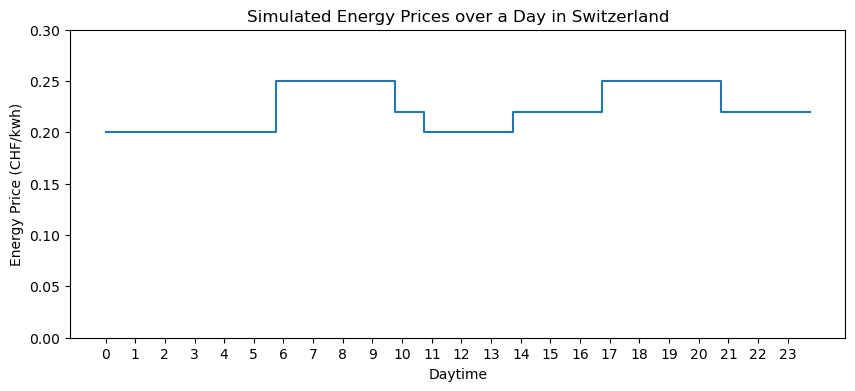

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 4))

# model energy prices over day
energy_prices = np.zeros(96)
energy_prices[:24] = 0.2
energy_prices[24:40] = 0.25
energy_prices[40:44] = 0.22
energy_prices[44:56] = 0.2
energy_prices[56:68] = 0.22
energy_prices[68:84] = 0.25
energy_prices[84:] = 0.22

time_values = np.arange(0, 24, 0.25)

plt.step(time_values, energy_prices)
plt.xlabel('Daytime')
plt.ylabel('Energy Price (CHF/kwh)')
plt.ylim(0, 0.3)
plt.title('Simulated Energy Prices over a Day in Switzerland')
plt.xticks(np.arange(0, 24, 1))
plt.show()

In [2]:
### pre-processing of reservation table: ###
# reservationfrom_discrete: discretize reservationfrom to 15 minutes 
# reservationto_discrete: discretize reservationto to 15 minutes 
# syscreatedate_discrete: discretize syscreatedate to 15 minutes 
# time_booking_to_bookingstart: time difference between syscreatedate and reservationfrom, in 15 min units
# reservation_duration: time difference between reservationfrom_discrete and reservationto_discrete, in 15 min units
# syscreatedate_daytime: time of the day of syscreatedate, in 15 min units
# reservationfrom_daytime: time of the day of reservationfrom, in 15 min units
# reservationto_daytime: time of the day of reservationto, in 15 min units
# booking_trip_same_day: boolean wether a trip was reserved on the same day as the trip or not

sql = """WITH reservations AS (
SELECT *,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(syscreatedate, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as syscreatedate_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationfrom, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationfrom_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_firststart_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_lastend_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationto, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationto_discrete
FROM mobility.reservation 
)
SELECT *, (drive_km/range)*100 AS required_soc,
EXTRACT(epoch FROM (reservationfrom_discrete - syscreatedate_discrete)) / 900 AS time_booking_to_bookingstart,
EXTRACT(epoch FROM (reservationto_discrete - reservationfrom_discrete)) / 900 AS reservation_duration
FROM reservations JOIN msc_2023_dominik.vehicle_information USING(vehicle_no) 
ORDER BY reservationfrom 
"""

data = pd.read_sql(sql, engine)
data["syscreatedate_daytime"] = data.syscreatedate_discrete.apply(lambda x: x.hour) * 4 + data.syscreatedate_discrete.apply(lambda x: x.minute) / 15
data["reservationfrom_daytime"] = data.reservationfrom_discrete.apply(lambda x: x.hour) * 4 + data.reservationfrom_discrete.apply(lambda x: x.minute) / 15
data["reservationto_daytime"] = data.reservationto_discrete.apply(lambda x: x.hour) * 4 + data.reservationto_discrete.apply(lambda x: x.minute) / 15
data["syscreatedate_discrete_date"] = pd.to_datetime(data['syscreatedate_discrete']).dt.date 
data["reservationfrom_discrete_date"] = pd.to_datetime(data['reservationfrom']).dt.date 
data["drive_firststart_discrete_date"] = pd.to_datetime(data['drive_firststart']).dt.date 
data["booking_trip_same_day"] = data["reservationfrom_discrete_date"] == data["syscreatedate_discrete_date"] 
data["syscreatedate_daytime_endofday"] = data["syscreatedate_daytime"]
data["reservationfrom_daytime_endofday"] = data["reservationfrom_daytime"]
data["reservationto_daytime_endofday"]  = data["reservationto_daytime"] 

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime"] = 0

cond = data["reservationfrom_discrete_date"] <= data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime_endofday"] = 96

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] + pd.Timedelta(days=1)
data.loc[cond, "syscreatedate_daytime_endofday"] = 0

cond = data["reservationfrom_daytime_endofday"] == 0
data.loc[cond, "reservationfrom_daytime_endofday"] = 96


cond = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond, "syscreatedate_daytime_endofday"] = data["reservationfrom_daytime_endofday"]


cond = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond, "syscreatedate_daytime"] = data["reservationfrom_daytime"]

cond = data["required_soc"] < 0
data.loc[cond, "required_soc"] = 0

cond = data["required_soc"] > 100
data.loc[cond, "required_soc"] = 100

data.to_sql("reservations_no_service_discrete", engine, schema="msc_2023_dominik", if_exists='replace')
data.head()

# Service reservations
sql = """WITH reservations AS (
SELECT *,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(syscreatedate, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as syscreatedate_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationfrom, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationfrom_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_firststart_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_lastend_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationto, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationto_discrete
FROM mobility.service_reservation 
)
SELECT *, (drive_km/range)*100 AS required_soc,
EXTRACT(epoch FROM (reservationfrom_discrete - syscreatedate_discrete)) / 900 AS time_booking_to_bookingstart,
EXTRACT(epoch FROM (reservationto_discrete - reservationfrom_discrete)) / 900 AS reservation_duration
FROM reservations JOIN msc_2023_dominik.vehicle_information USING(vehicle_no) 
ORDER BY reservationfrom 
"""

data = pd.read_sql(sql, engine)
data["syscreatedate_daytime"] = data.syscreatedate_discrete.apply(lambda x: x.hour) * 4 + data.syscreatedate_discrete.apply(lambda x: x.minute) / 15
data["reservationfrom_daytime"] = data.reservationfrom_discrete.apply(lambda x: x.hour) * 4 + data.reservationfrom_discrete.apply(lambda x: x.minute) / 15
data["reservationto_daytime"] = data.reservationto_discrete.apply(lambda x: x.hour) * 4 + data.reservationto_discrete.apply(lambda x: x.minute) / 15
data["syscreatedate_discrete_date"] = pd.to_datetime(data['syscreatedate_discrete']).dt.date 
data["reservationfrom_discrete_date"] = pd.to_datetime(data['reservationfrom']).dt.date 
data["drive_firststart_discrete_date"] = pd.to_datetime(data['drive_firststart']).dt.date 
data["booking_trip_same_day"] = data["reservationfrom_discrete_date"] == data["syscreatedate_discrete_date"] 
data["syscreatedate_daytime_endofday"] = data["syscreatedate_daytime"]
data["reservationfrom_daytime_endofday"] = data["reservationfrom_daytime"]
data["reservationto_daytime_endofday"]  = data["reservationto_daytime"] 

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime"] = 0

cond = data["reservationfrom_discrete_date"] <= data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime_endofday"] = 96

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] + pd.Timedelta(days=1)
data.loc[cond, "syscreatedate_daytime_endofday"] = 0

cond = data["reservationfrom_daytime_endofday"] == 0
data.loc[cond, "reservationfrom_daytime_endofday"] = 96


cond = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond, "syscreatedate_daytime_endofday"] = data["reservationfrom_daytime_endofday"]


cond = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond, "syscreatedate_daytime"] = data["reservationfrom_daytime"]

# no energy consumption during service trips
data["required_soc"] = 0

data.to_sql("service_reservations_discrete", engine, schema="msc_2023_dominik", if_exists='replace')
data.head()

## JOIN both tables 
sql1 = """SELECT * FROM msc_2023_dominik.reservations_no_service_discrete"""
reservations_no_service = pd.read_sql(sql1, engine).drop(["level_0"], axis = 1)

sql2 = """SELECT * FROM msc_2023_dominik.service_reservations_discrete"""
reservations_service = pd.read_sql(sql2, engine).drop(["level_0"], axis = 1)

union_df = pd.concat([reservations_no_service, reservations_service], axis=0)
union_df.to_sql("reservations_discrete", engine, schema="msc_2023_dominik", if_exists='replace')


884

In [3]:
union_df["required_soc"].isnull().values.any()

True

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(union_df[union_df["required_soc"].isnull() == True].head(10))

         vehicle_no  index  reservation_no  person_no reservationtype  \
146697       116352    385        24703595     917296          Normal   
395238       123347   2456        24996581     995868          Normal   
754911       115721   4353        25414997     988096          Normal   
854261       122861   2976        25553305     462772          Normal   
893979       116907   4212        25575600     960870          Normal   
919223       125000    605        25635876      74999          Normal   
1143454      116647    560        25914197    1101645          Normal   
1454134      115448   4041        26298212     799494          Normal   
1825973      114889   3435        26763406    1057880          Normal   

        reservationstate                                tripmode  \
146697     abgeschlossen  Return (Rückgabe an derselben Station)   
395238          geändert  Return (Rückgabe an derselben Station)   
754911     abgeschlossen  Return (Rückgabe an derselben Station) 

In [21]:
data["required_soc"].mean()

0.0

In [2]:
### pre-processing of service reservation table: ###
# reservationfrom_discrete: discretize reservationfrom to 15 minutes 
# reservationto_discrete: discretize reservationto to 15 minutes 
# syscreatedate_discrete: discretize syscreatedate to 15 minutes 
# time_booking_to_bookingstart: time difference between syscreatedate and reservationfrom, in 15 min units
# reservation_duration: time difference between reservationfrom_discrete and reservationto_discrete, in 15 min units
# syscreatedate_daytime: time of the day of syscreatedate, in 15 min units
# reservationfrom_daytime: time of the day of reservationfrom, in 15 min units
# reservationto_daytime: time of the day of reservationto, in 15 min units
# booking_trip_same_day: boolean wether a trip was reserved on the same day as the trip or not

sql = """WITH reservations AS (
SELECT
    drive_km::float, 
    revenue_duration::float, 
    revenue_distance::float, 
    revenue_other::float,  
    reservation_no, 
    person_no, 
    vehicle_no, 
    reservationtype, 
    reservationstate, 
    tripmode, 
    syscreatedate, 
    reservationfrom, 
    reservationto, 
    canceldate,
    brand_name, 
    model_name, 
    energytypegroup, 
    drive_firststart, 
    drive_lastend, 
    start_station_no, 
    end_station_no,
    index,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(syscreatedate, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as syscreatedate_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationfrom, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationfrom_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_firststart_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_lastend_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationto, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationto_discrete
FROM mobility.service_reservation JOIN discrete.soc USING(reservation_no) 
)
SELECT *, 
EXTRACT(epoch FROM (reservationfrom_discrete - syscreatedate_discrete)) / 900 AS time_booking_to_bookingstart,
EXTRACT(epoch FROM (reservationto_discrete - reservationfrom_discrete)) / 900 AS reservation_duration
FROM reservations 
ORDER BY reservationfrom   
"""

data = pd.read_sql(sql, engine)
data["syscreatedate_daytime"] = data.syscreatedate_discrete.apply(lambda x: x.hour) * 4 + data.syscreatedate_discrete.apply(lambda x: x.minute) / 15
data["reservationfrom_daytime"] = data.reservationfrom_discrete.apply(lambda x: x.hour) * 4 + data.reservationfrom_discrete.apply(lambda x: x.minute) / 15
data["reservationto_daytime"] = data.reservationto_discrete.apply(lambda x: x.hour) * 4 + data.reservationto_discrete.apply(lambda x: x.minute) / 15
data["syscreatedate_discrete_date"] = pd.to_datetime(data['syscreatedate_discrete']).dt.date 
data["reservationfrom_discrete_date"] = pd.to_datetime(data['reservationfrom_discrete']).dt.date 
data["drive_firststart_discrete_date"] = pd.to_datetime(data['drive_firststart_discrete']).dt.date 
data["booking_trip_same_day"] = data["reservationfrom_discrete_date"] == data["syscreatedate_discrete_date"] 
data["syscreatedate_daytime_endofday"] = data["syscreatedate_daytime"]
data["reservationfrom_daytime_endofday"] = data["reservationfrom_daytime"]
data["reservationto_daytime_endofday"]  = data["reservationto_daytime"] 

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime"] = 0

cond = data["reservationfrom_discrete_date"] <= data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime_endofday"] = 96

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] + pd.Timedelta(days=1)
data.loc[cond, "syscreatedate_daytime_endofday"] = 0

cond = data["reservationfrom_daytime_endofday"] == 0
data.loc[cond, "reservationfrom_daytime_endofday"] = 96


cond2 = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond2, "syscreatedate_daytime_endofday"] = data["reservationfrom_daytime_endofday"]


cond2 = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond2, "syscreatedate_daytime"] = data["reservationfrom_daytime"]

data.to_sql("service_reservations_discrete", engine, schema="msc_2023_dominik", if_exists='replace')



### pre-processing of reservation table: ###
# reservationfrom_discrete: discretize reservationfrom to 15 minutes 
# reservationto_discrete: discretize reservationto to 15 minutes 
# syscreatedate_discrete: discretize syscreatedate to 15 minutes 
# time_booking_to_bookingstart: time difference between syscreatedate and reservationfrom, in 15 min units
# reservation_duration: time difference between reservationfrom_discrete and reservationto_discrete, in 15 min units
# syscreatedate_daytime: time of the day of syscreatedate, in 15 min units
# reservationfrom_daytime: time of the day of reservationfrom, in 15 min units
# reservationto_daytime: time of the day of reservationto, in 15 min units
# booking_trip_same_day: boolean wether a trip was reserved on the same day as the trip or not

sql = """WITH reservations AS (
SELECT *,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(syscreatedate, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as syscreatedate_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationfrom, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationfrom_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_firststart_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as drive_lastend_discrete,
(timestamp 'epoch' + (((EXTRACT(epoch FROM TO_TIMESTAMP(reservationto, 'YYYY-MM-DD HH24:MI:SS.MS'))::int + 450) / 900) * 900) * INTERVAL '1 second') as reservationto_discrete
FROM mobility.reservation 
)
SELECT *, 
EXTRACT(epoch FROM (reservationfrom_discrete - syscreatedate_discrete)) / 900 AS time_booking_to_bookingstart,
EXTRACT(epoch FROM (reservationto_discrete - reservationfrom_discrete)) / 900 AS reservation_duration
FROM reservations LEFT OUTER JOIN discrete.soc USING(reservation_no)
ORDER BY reservationfrom 
"""

data = pd.read_sql(sql, engine)
data["syscreatedate_daytime"] = data.syscreatedate_discrete.apply(lambda x: x.hour) * 4 + data.syscreatedate_discrete.apply(lambda x: x.minute) / 15
data["reservationfrom_daytime"] = data.reservationfrom_discrete.apply(lambda x: x.hour) * 4 + data.reservationfrom_discrete.apply(lambda x: x.minute) / 15
data["reservationto_daytime"] = data.reservationto_discrete.apply(lambda x: x.hour) * 4 + data.reservationto_discrete.apply(lambda x: x.minute) / 15
data["syscreatedate_discrete_date"] = pd.to_datetime(data['syscreatedate_discrete']).dt.date 
data["reservationfrom_discrete_date"] = pd.to_datetime(data['reservationfrom_discrete']).dt.date 
data["drive_firststart_discrete_date"] = pd.to_datetime(data['drive_firststart_discrete']).dt.date 
data["booking_trip_same_day"] = data["reservationfrom_discrete_date"] == data["syscreatedate_discrete_date"] 
data["syscreatedate_daytime_endofday"] = data["syscreatedate_daytime"]
data["reservationfrom_daytime_endofday"] = data["reservationfrom_daytime"]
data["reservationto_daytime_endofday"]  = data["reservationto_daytime"] 

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime"] = 0

cond = data["reservationfrom_discrete_date"] <= data["syscreatedate_discrete_date"] 
data.loc[cond, "syscreatedate_daytime_endofday"] = 96

cond = data["reservationfrom_discrete_date"] > data["syscreatedate_discrete_date"] + pd.Timedelta(days=1)
data.loc[cond, "syscreatedate_daytime_endofday"] = 0

cond = data["reservationfrom_daytime_endofday"] == 0
data.loc[cond, "reservationfrom_daytime_endofday"] = 96


cond2 = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond2, "syscreatedate_daytime_endofday"] = data["reservationfrom_daytime_endofday"]


cond2 = data["reservationfrom_discrete"] < data["syscreatedate_discrete"] 
data.loc[cond2, "syscreatedate_daytime"] = data["reservationfrom_daytime"]

data.to_sql("reservations_no_service_discrete", engine, schema="msc_2023_dominik", if_exists='replace')
data.head()


## JOIN both tables 
sql1 = """SELECT * FROM msc_2023_dominik.reservations_no_service_discrete"""
reservations_no_service = pd.read_sql(sql1, engine).drop(["level_0"], axis = 1)

sql2 = """SELECT * FROM msc_2023_dominik.service_reservations_discrete"""
reservations_service = pd.read_sql(sql2, engine).drop(["level_0"], axis = 1)

union_df = pd.concat([reservations_no_service, reservations_service], axis=0)
union_df.to_sql("reservations_discrete", engine, schema="msc_2023_dominik", if_exists='replace')


897

In [40]:
### create indices for fast data loading in environment ###
conn = psycopg2.connect(dbname=credentials['database_name'], user=credentials['username'], password=credentials['password'], host=credentials['host'])
cur = conn.cursor()
#cur.execute("CREATE INDEX reservationfrom_discrete_date ON msc_2023_dominik.reservations_discrete USING hash(reservationfrom_discrete_date)")
#cur.execute("CREATE INDEX reservationfrom_discrete_index_b_tree ON msc_2023_dominik.reservations_discrete (reservationfrom_discrete)")
#for i in range(0,83):
#    cur.execute("CREATE INDEX vehicle_no_b_tree_index_week_{} ON msc_2023_dominik.discrete_weeks_{} (vehicle_no)".format(i,i))
    
conn.commit()
cur.close()
conn.close()

In [8]:
### pre-processing of station tables: ###
# Contains all stations in the mobility.station table with valid geometry, that were used during the 
# observation period for bookings (mobility.reservation and mobility.service_reservation)

sql = "WITH stations AS (SELECT DISTINCT start_station_no FROM (SELECT DISTINCT start_station_no FROM mobility.reservation UNION SELECT DISTINCT start_station_no FROM mobility.service_reservation) AS station_union) SELECT station_no, ST_Transform(ST_SetSRID(geom,4326), 2056) AS geom FROM stations LEFT OUTER JOIN mobility.station ON start_station_no = station_no WHERE geom is not NULL"
gdf = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
gdf.to_postgis("distinct_stations", engine, schema="msc_2023_dominik", if_exists='replace')  

In [3]:
### pre-processing of vehicle tables: ###
# get information about each car used in the discrete tables
# replace some car types, which are not used anymore (Budget Electro by Budget, Combi Electro by Combi)
sql = """SELECT vehicle_no, mobility.simulated_ev.model_name, mobility.simulated_ev.brand_name, charge_power, battery_capacity, range, vehicle_category 
         FROM mobility.simulated_ev 
         FULL OUTER JOIN mobility.vehicle USING (vehicle_no) 
         RIGHT OUTER JOIN discrete.discrete_weeks_0 using (vehicle_no)"""
data = pd.read_sql(sql, engine)
data = data.replace(["Budget Electro"], 'Budget')
data = data.replace(['Combi Electro'], 'Combi')
data.to_sql("vehicles_preprocessing", engine, schema="msc_2023_dominik", if_exists='replace')

### vehicle types: ###
# get car information for each category
sql = """WITH vehicles AS (
                            SELECT *
                            FROM msc_2023_dominik.vehicles_preprocessing 
        )
        SELECT model_name, brand_name, charge_power, battery_capacity, range, vehicle_category 
        FROM vehicles
        WHERE model_name IS NOT NULL
        GROUP by model_name, brand_name, charge_power, battery_capacity, range, vehicle_category 
        ORDER BY vehicle_category"""
data = pd.read_sql(sql, engine)
data.to_sql("vehicles_types", engine, schema="msc_2023_dominik", if_exists='replace')

### Vehicle Information table: ###
# create final vehicle information table; containing all vehicle informatino for each car in the discrete tables
sql = """
WITH vehicles AS (
    SELECT vehicle_no, vehicle_category
    FROM msc_2023_dominik.vehicles_preprocessing 
), 
vehicle_categories AS (
    SELECT *
    FROM msc_2023_dominik.vehicles_types
)
SELECT *
FROM vehicles JOIN vehicle_categories USING(vehicle_category)
"""
data = pd.read_sql(sql, engine)
data = data.drop(["index"], axis = 1)
data.to_sql("vehicle_information", engine, schema="msc_2023_dominik", if_exists='replace')

420